In [1]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Estimate daily concentrations of key chemical species

Aim: Derive daily time series of concentrations of the key variables of interest to the marine folk.

Time period of interest to be determined. Storm Hans is of particular interest, but we may be interested all the way back to 1990. **Discuss with Helene**

Do this using either:
1) Regressions with sensor data data (for 2023 only and Glomma only) (derived in notebook flux1_regressions), if regressions were meaningful
2) Regressions with discharge data (also derived in notebook flux1_regressions)
3) Interpolation of grab sample data if data frequency appears high enough
4) Filling using e.g. monthly median values if none of the above are appropriate

Output of this notebook is then used to estimate fluxes to the fjord.

In [2]:
river_names_mapper = {
    'Q_daily-mean_Drammenselva_Mjøndalen bru_12': 'discharge_Drammenselva v/Krokstadelva',
    'Q_daily-mean_Glomma_Solbergfoss_2': 'discharge_Glomma v/Sarpefossen',
    'Q_daily-mean_Numedalslågen_Holmfoss_15': 'discharge_Numedalslågen v/E18'
}

### 1. User inputs

In [3]:
chem_df = pd.read_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_key_wc_species_cleaned.csv')
chem_df['sample_date'] = pd.to_datetime(chem_df['sample_date'])
chem_df.head()

,sample_date,station_id,station_code,station_name,Farge_mg Pt/l,DIN_mg/l,PO4-P_µg/l,SiO2_mg/l,TOC_mg/l,TOTN_µg/l,TOTP/F_µg/l P,TOTP_P_µg/l P,TSM_mg/l
0,1990-01-11,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,0.5,NaN,NaN,350.0,NaN,NaN,0.8
1,1990-02-12,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,2.0,NaN,NaN,419.0,NaN,NaN,2.0
2,1990-03-13,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,1.5,NaN,NaN,405.0,NaN,NaN,1.4
3,1990-04-18,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,1.5,NaN,NaN,399.0,NaN,NaN,1.3
4,1990-05-21,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,0.5,NaN,NaN,317.0,NaN,NaN,1.7


In [4]:
q_directory = r'../../data/river/discharge/clean'

# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(q_directory, '*.csv'))

# Initialize an empty DataFrame to hold the combined data
discharge_df = pd.DataFrame()

# Loop through each file and process it
for file in csv_files:
    # Extract the river name from the file name
    river_name = os.path.basename(file).split('.')[0]
    
    # Read the CSV file
    df = pd.read_csv(file)
    
     # Select the Date and discharge columns, and rename the discharge column
    discharge_column = df[['Date', 'Discharge']].rename(columns={'Discharge': river_names_mapper[river_name]})
    
    # Merge the discharge columns on the Date column
    if discharge_df.empty:
        discharge_df = discharge_column
    else:
        discharge_df = pd.merge(discharge_df, discharge_column, on='Date', how='outer')


# Convert 'Date' to datetime format
discharge_df['Date'] = pd.to_datetime(discharge_df['Date'])

# Extract the year and add it as a new column
# discharge_df['year'] = discharge_df['Date'].dt.year

# discharge_df.set_index('Date', inplace=True)
discharge_df['Date'] = pd.to_datetime(discharge_df['Date'])
discharge_df.head()

,Date,discharge_Glomma v/Sarpefossen,discharge_Drammenselva v/Krokstadelva,discharge_Numedalslågen v/E18
0,1990-01-01,425.0,264.681,75.875
1,1990-01-02,500.0,264.681,75.160
2,1990-01-03,500.0,260.214,73.044
3,1990-01-04,500.0,260.214,75.160
4,1990-01-05,472.0,260.214,81.769


To do: ## 2. Linear regression to estimate daily concentrations 

## 3. Regressions with discharge data
### 3.1. Regressions with data that is available at daily frequency (discharges)

To do with sensors too...

In [5]:
# Merge datasets on date to keep only the dates where chemistry data is available

discharge_long_df = discharge_df.melt(id_vars=['Date'], 
                                      var_name='station_name', 
                                      value_name='discharge')

discharge_long_df['station_name'] = discharge_long_df['station_name'].str.replace('discharge_', '')
discharge_long_df

discharge_long_df['Date'] = pd.to_datetime(discharge_long_df['Date'])

chem_df.reset_index(inplace=True)
chem_df['sample_date'] = chem_df['sample_date'].dt.date
chem_df.rename(columns={'sample_date': 'Date'}, inplace=True)
chem_df['Date'] = pd.to_datetime(chem_df['Date'])

merged_df = pd.merge(chem_df, discharge_long_df, 
                     how='inner', 
                     left_on=['Date', 'station_name'], 
                     right_on=['Date', 'station_name'])

merged_df.head()

,index,Date,station_id,station_code,station_name,Farge_mg Pt/l,DIN_mg/l,PO4-P_µg/l,SiO2_mg/l,TOC_mg/l,TOTN_µg/l,TOTP/F_µg/l P,TOTP_P_µg/l P,TSM_mg/l,discharge
0,0,1990-01-11,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,0.5,NaN,NaN,350.0,NaN,NaN,0.8,260.214
1,1,1990-02-12,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,2.0,NaN,NaN,419.0,NaN,NaN,2.0,321.638
2,2,1990-03-13,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,1.5,NaN,NaN,405.0,NaN,NaN,1.4,323.871
3,3,1990-04-18,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,1.5,NaN,NaN,399.0,NaN,NaN,1.3,345.090
4,4,1990-05-21,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,0.5,NaN,NaN,317.0,NaN,NaN,1.7,323.871


In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          1629 non-null   int64         
 1   Date           1629 non-null   datetime64[ns]
 2   station_id     1629 non-null   int64         
 3   station_code   1629 non-null   object        
 4   station_name   1629 non-null   object        
 5   Farge_mg Pt/l  169 non-null    float64       
 6   DIN_mg/l       1439 non-null   float64       
 7   PO4-P_µg/l     1629 non-null   float64       
 8   SiO2_mg/l      1082 non-null   float64       
 9   TOC_mg/l       1381 non-null   float64       
 10  TOTN_µg/l      1391 non-null   float64       
 11  TOTP/F_µg/l P  169 non-null    float64       
 12  TOTP_P_µg/l P  161 non-null    float64       
 13  TSM_mg/l       1585 non-null   float64       
 14  discharge      1629 non-null   float64       
dtypes: datetime64[ns](1),

In [7]:
# filtered_df = merged_df[merged_df['station_code'] == 'DRA1'][['Date', 'TOC_mg/l', 'discharge']]
# filtered_df['log_TOC'] = np.log10(filtered_df['TOC_mg/l'])
# filtered_df['log_discharge'] = np.log10(filtered_df['discharge'])
# # X = sm.add_constant(filtered_df['discharge'])  # independent variable
# # y = filtered_df['TSM_mg/l']  # dependent variable
# X = sm.add_constant(filtered_df['log_discharge'])  # independent variable
# y = filtered_df['log_TOC']  # dependent variable

# model = sm.OLS(y, X)
# results = model.fit()
# results.summary()

In [8]:
# filtered_df = filtered_df.dropna(subset=['TOC_mg/l', 'discharge'])
# filtered_df
# filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])
# filtered_df.set_index('Date', inplace=True)
# filtered_df = filtered_df[~filtered_df.index.duplicated(keep='first')]
# monthly_index = pd.date_range(start=filtered_df.index.min(), end=filtered_df.index.max(), freq='MS')
# filtered_df = filtered_df.reindex(monthly_index)
# filtered_df

In [9]:
# def predict_toc(discharge):
#         log_discharge = np.log(discharge)
#         log_toc_pred = results.params['const'] + results.params['log_discharge'] * log_discharge
#         toc_pred = np.exp(log_toc_pred)
#         return toc_pred
# filtered_df['log_TOC_pred'] = filtered_df.apply(
#         lambda row: predict_toc(row['log_discharge']) if pd.isna(row['log_TOC']) and not pd.isna(row['log_discharge']) else row['log_TOC'],
#         axis=1
# )

# filtered_df

In [10]:
# plt.scatter(filtered_df['Date'],filtered_df['log_TOC'], label='log TOC')
# plt.scatter(filtered_df['Date'],filtered_df['log_TOC_pred'] , label='log_TOC_pred')

In [ ]:
### Test

In [11]:
merged_df.keys()

Index(['index', 'Date', 'station_id', 'station_code', 'station_name',
       'Farge_mg Pt/l', 'DIN_mg/l', 'PO4-P_µg/l', 'SiO2_mg/l', 'TOC_mg/l',
       'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'TSM_mg/l', 'discharge'],
      dtype='object')

In [13]:
data = merged_df.set_index('Date')
stations = data['station_id'].unique()

station_models = {}

for station in stations:
    station_data = data[data['station_id'] == station]
    
    X = station_data[['discharge']]
    y = station_data.drop(columns=['index', 'station_id', 'station_code', 'station_name', 'discharge'])

    models = {}
    for column in y.columns:
        valid_data = station_data[['discharge', column]].dropna()
        if not valid_data.empty:
            valid_data = valid_data[(valid_data['discharge'] > 0) & (valid_data[column] > 0)]
            if not valid_data.empty:
                valid_data['log10_discharge'] = np.log10(valid_data['discharge'])
                X = sm.add_constant(valid_data['log10_discharge'])  
                y = valid_data[column]  
                
                model = sm.OLS(y, X).fit()
                models[column] = model

    station_models[station] = models

for station, models in station_models.items():
    print(f"\nStation {station} - Chemistry parameters with models:")
    print(models.keys())
    for column, model in models.items():
        print(f"\nSummary for {column} at Station {station}:")
        print(model.summary())


Station 40352 - Chemistry parameters with models:
dict_keys(['Farge_mg Pt/l', 'DIN_mg/l', 'PO4-P_µg/l', 'SiO2_mg/l', 'TOC_mg/l', 'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'TSM_mg/l'])

Summary for Farge_mg Pt/l at Station 40352:
                            OLS Regression Results                            
Dep. Variable:          Farge_mg Pt/l   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     74.50
Date:                Wed, 06 Nov 2024   Prob (F-statistic):           3.63e-12
Time:                        09:09:48   Log-Likelihood:                -190.75
No. Observations:                  63   AIC:                             385.5
Df Residuals:                      61   BIC:                             389.8
Df Model:                           1                                         
Covariance Type:            nonrobust                 

In [14]:
# Interpolate daily chemistry data using the trained models for each station
daily_chemistry_all_stations = pd.DataFrame()

for station in stations:
    station_data = data[data['station_id'] == station]
    daily_discharge = station_data[['discharge']]
    daily_chemistry = pd.DataFrame(index=daily_discharge.index)
    
    models = station_models[station]
    
    for column, model in models.items():
        # Predict on log-transformed data and back-transform
        daily_chemistry[column] = np.exp(model.predict(sm.add_constant(np.log10(daily_discharge.replace(0, np.nan).dropna()))))
    
    # Combine daily discharge with interpolated daily chemistry data for the current station
    daily_chemistry['discharge'] = daily_discharge
    
    # Add a column for the station ID
    daily_chemistry['station_id'] = station
    
    # Append to the final DataFrame containing all stations
    daily_chemistry_all_stations = pd.concat([daily_chemistry_all_stations, daily_chemistry])
daily_chemistry_all_stations

,Farge_mg Pt/l,DIN_mg/l,PO4-P_µg/l,SiO2_mg/l,TOC_mg/l,TOTN_µg/l,TOTP/F_µg/l P,TOTP_P_µg/l P,TSM_mg/l,discharge,station_id
Date,,,,,,,,,,,
1990-01-11,1.887810e+08,4.150639e+115,7.052314,14.565010,26.758764,2.034165e+182,7.633904,135.181236,5.809390,260.214,40352
1990-02-12,1.003319e+09,3.557613e+118,16.459682,15.989541,30.684485,1.044968e+186,8.440018,211.908964,10.885540,321.638,40352
1990-03-13,1.059555e+09,4.435202e+118,16.921483,16.038325,30.821926,1.381167e+186,8.467723,215.041891,11.111007,323.871,40352
1990-04-18,1.747303e+09,3.351282e+119,21.810349,16.492794,32.111668,1.784093e+187,8.726129,246.028492,13.409699,345.090,40352
1990-05-21,1.059555e+09,4.435202e+118,16.921483,16.038325,30.821926,1.381167e+186,8.467723,215.041891,11.111007,323.871,40352
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22,2.504279e+14,8.114688e+131,12691.299432,40.660473,92.770002,3.725072e+224,86.685760,156978.813024,187364.234296,1489.729,40356
2024-06-03,2.153041e+14,2.392904e+133,12182.713543,40.814488,91.091511,4.409658e+225,86.903615,151814.292236,168055.977136,1445.896,40356
2024-06-12,1.450080e+14,1.670707e+137,10946.775338,41.220090,86.843507,2.828874e+228,87.476023,139095.386180,126448.494763,1337.250,40356


In [15]:
daily_chemistry_all_stations['station_id'].unique()

array([40352, 40355, 40356])

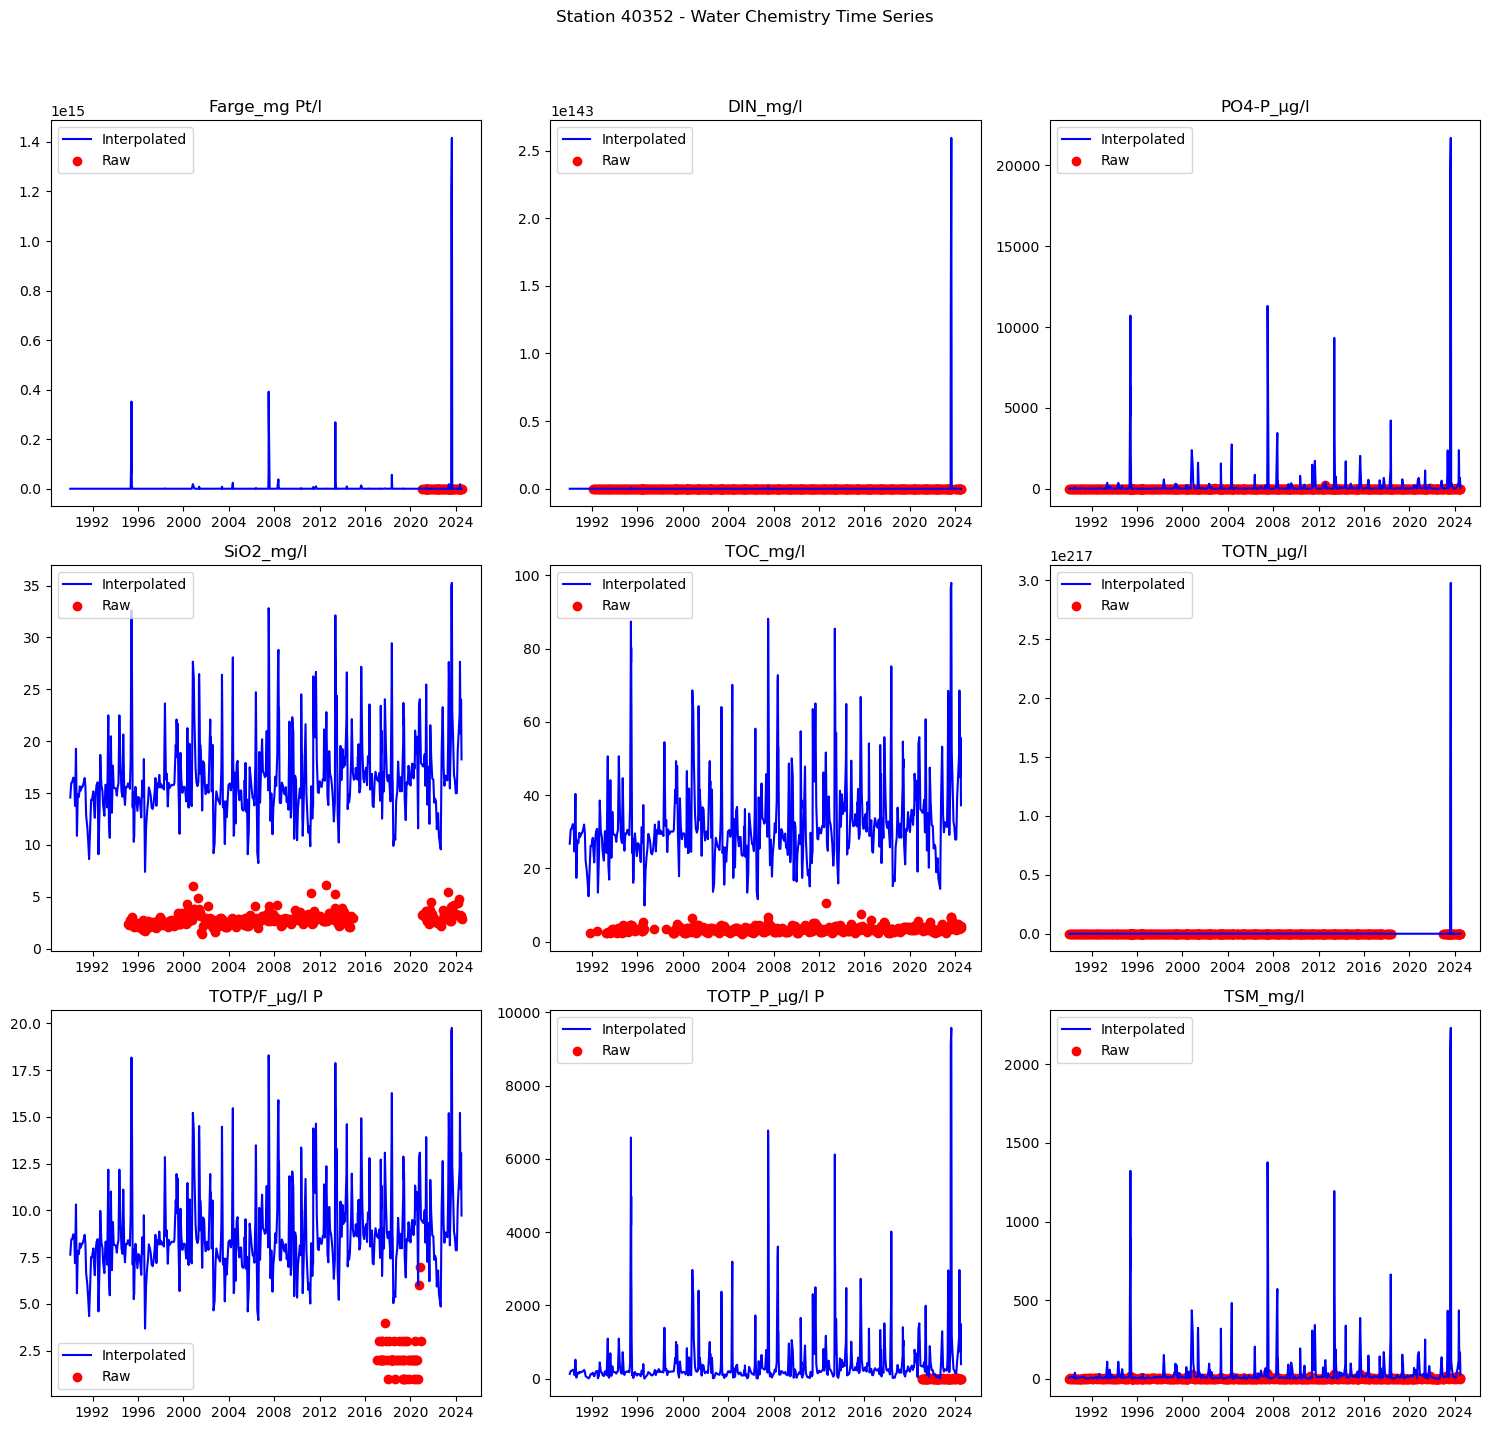

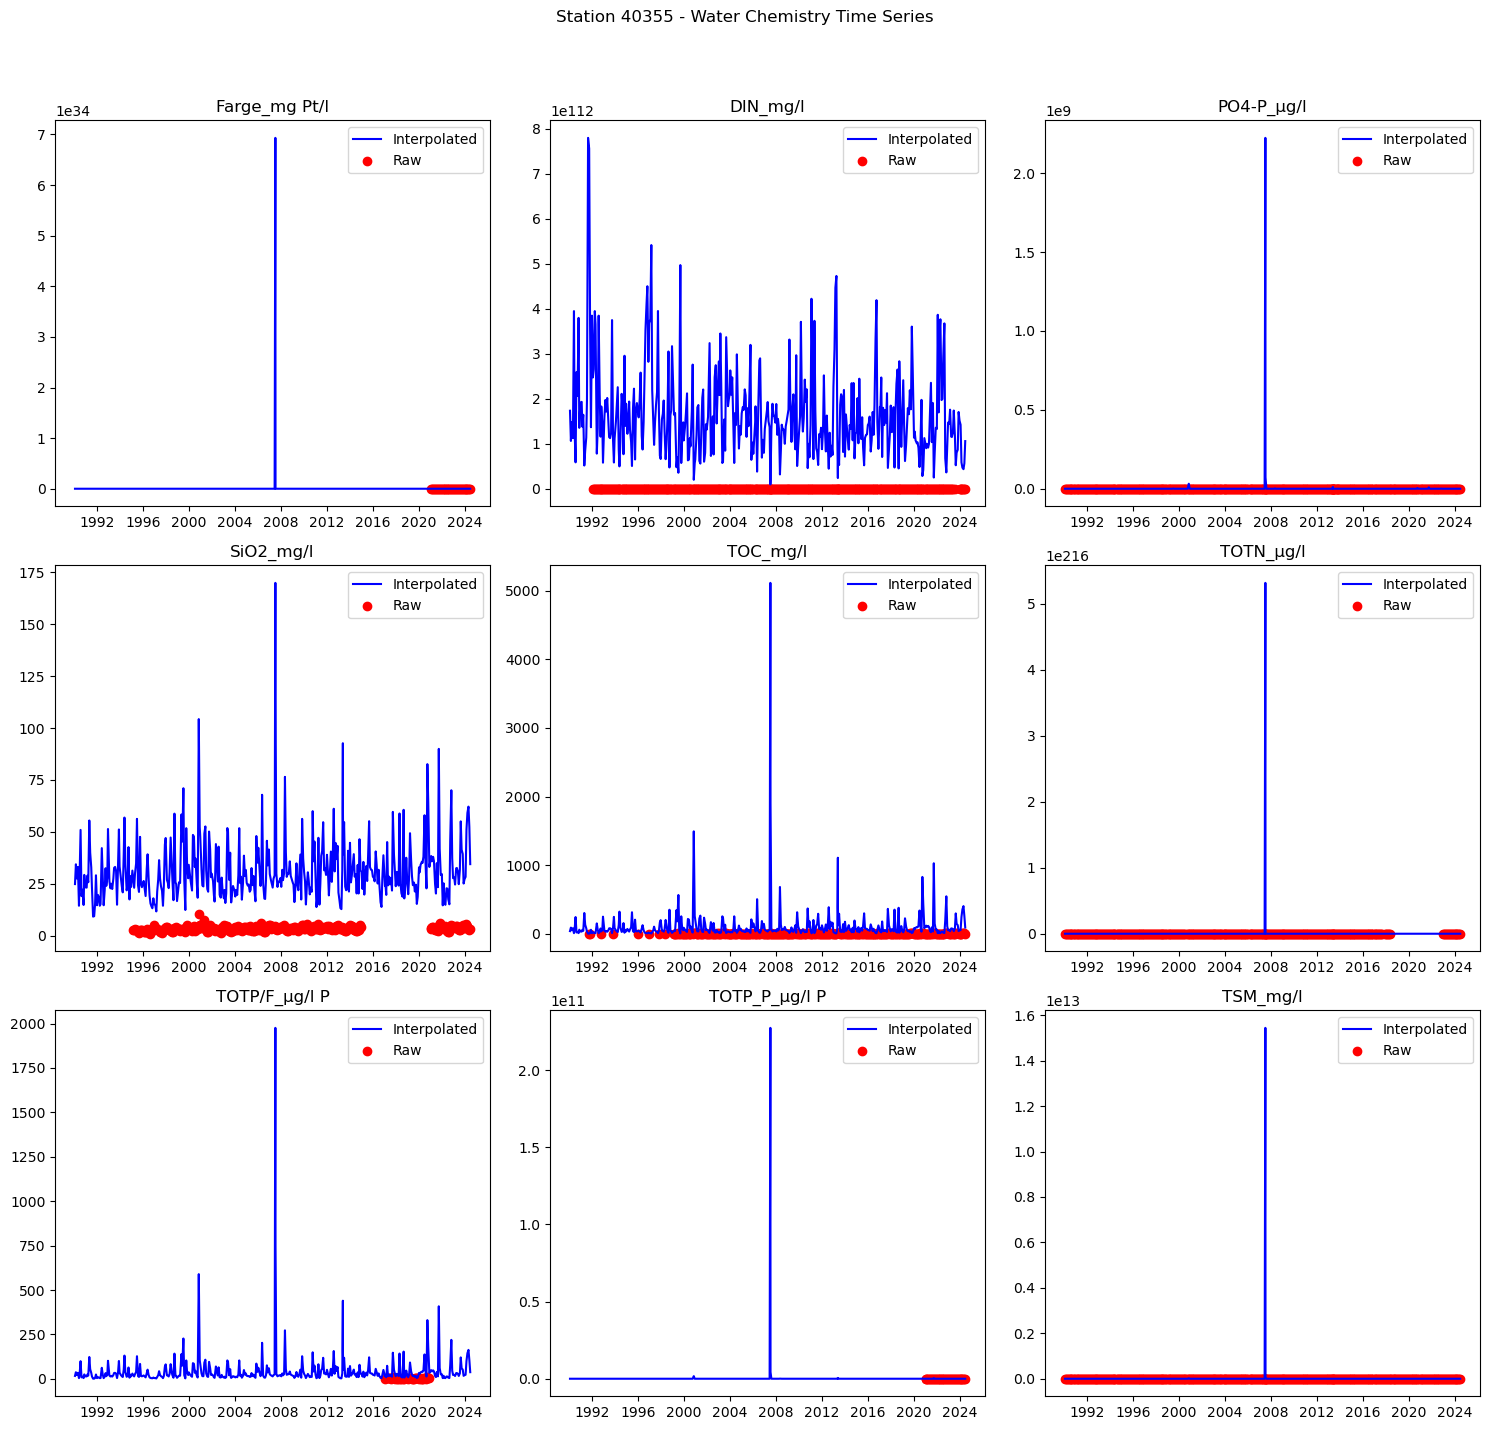

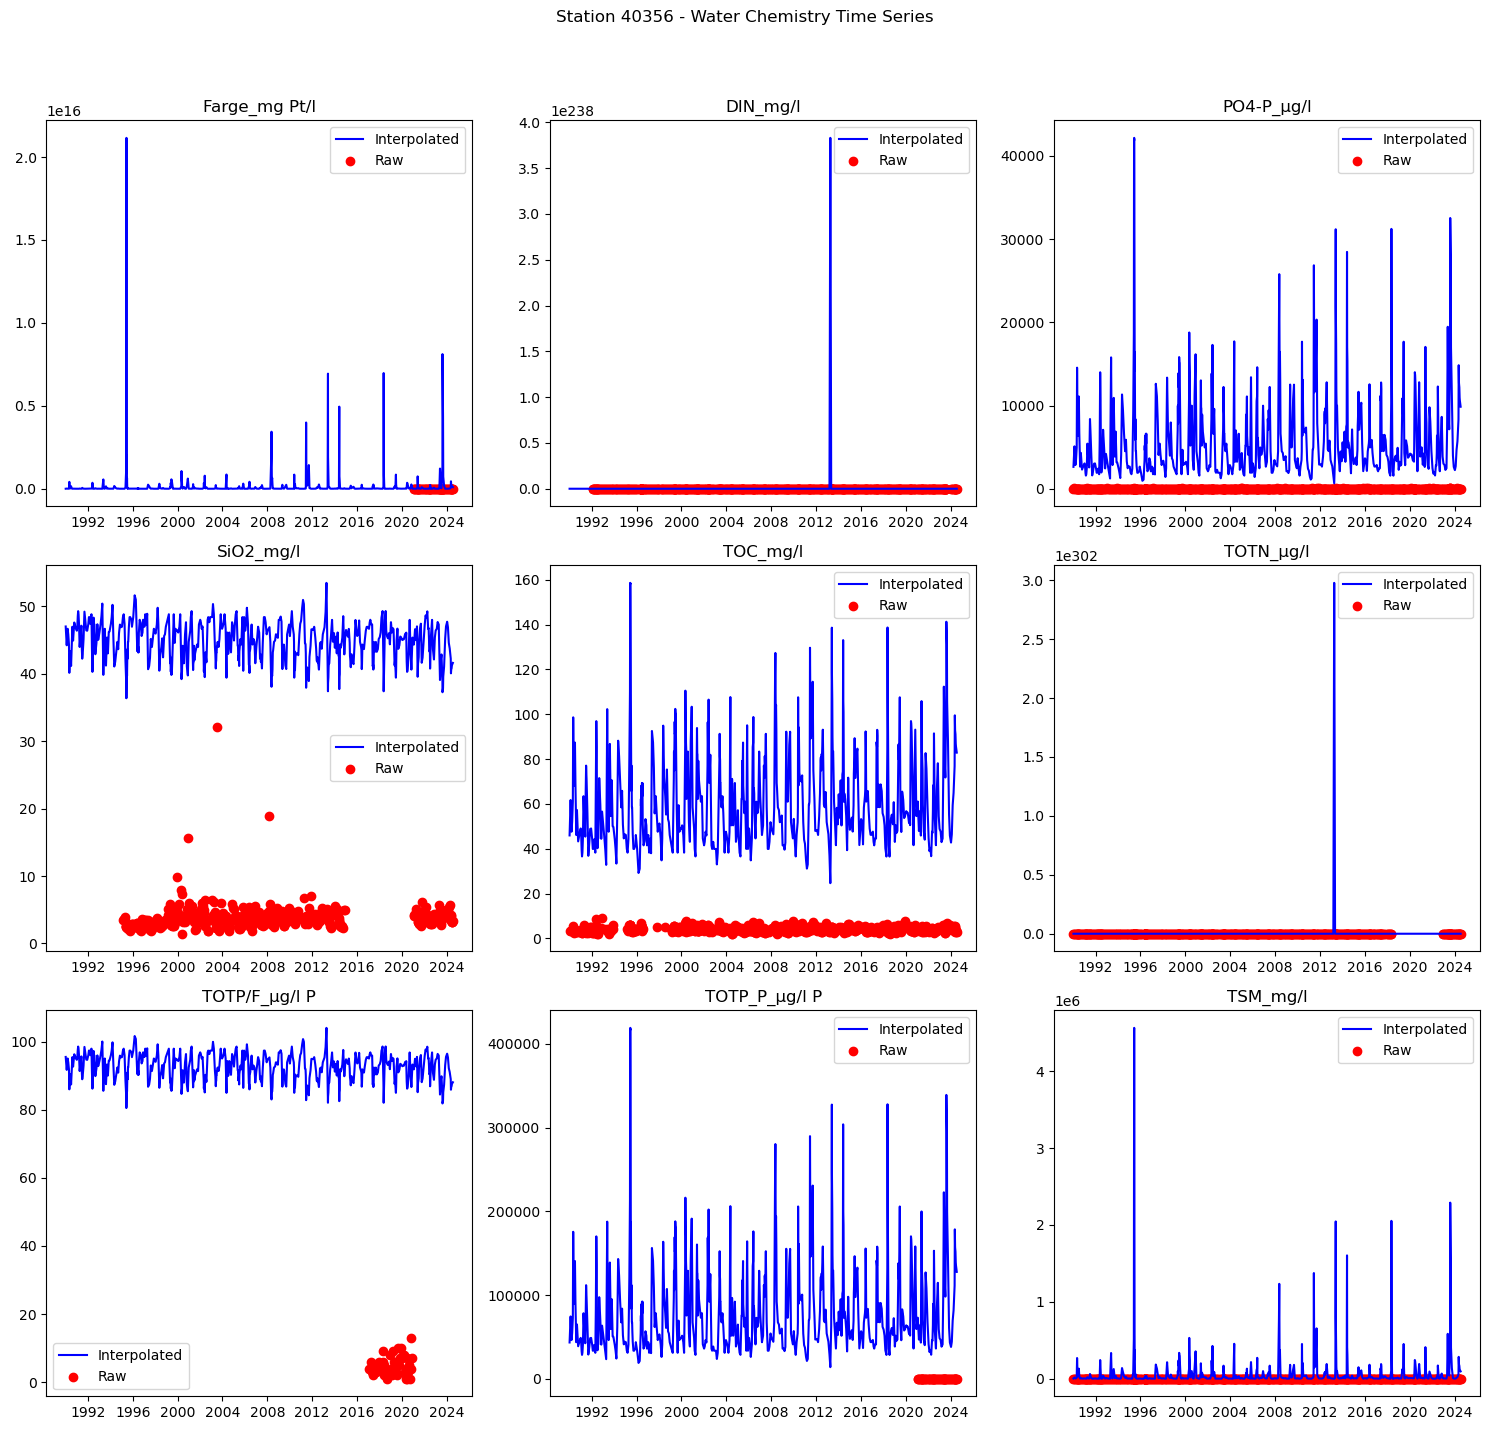

In [18]:
raw_chemistry_data = chem_df.set_index('Date')

variables = ['Farge_mg Pt/l', 'DIN_mg/l', 'PO4-P_µg/l', 'SiO2_mg/l', 'TOC_mg/l',
             'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 'TSM_mg/l']

# Plot timeseries of each variable for each station separately together with the raw water chemistry data
for station in stations:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    fig.suptitle(f'Station {station} - Water Chemistry Time Series')
    
    for i, variable in enumerate(variables):
        ax = axes[i // 3, i % 3]
        ax.plot(daily_chemistry_all_stations[daily_chemistry_all_stations['station_id'] == station].index,
                daily_chemistry_all_stations[daily_chemistry_all_stations['station_id'] == station][variable],
                label='Interpolated', color='blue')
        
        ax.scatter(raw_chemistry_data[raw_chemistry_data['station_id'] == station].index,
                   raw_chemistry_data[raw_chemistry_data['station_id'] == station][variable],
                   label='Raw', color='red')
        
        ax.set_title(variable)
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()